In [2]:
# | code-fold: true
# | code-summary: "Load packages"
# | output: false

import os
import numpy as np
import jax
from jax import numpy as jnp
import pytest
from types import SimpleNamespace
from sympy import cos, pi

from library.fvm.solver import Solver, Settings
from library.fvm.ode import RK1
import library.fvm.reconstruction as recon
import library.fvm.timestepping as timestepping
import library.fvm.flux as flux
import library.fvm.nonconservative_flux as nc_flux
from library.model.boundary_conditions import BoundaryCondition
from library.model.models.basisfunctions import Basisfunction, Legendre_shifted
from library.model.models.basismatrices import Basismatrices

from library.model.model import *
import library.model.initial_conditions as IC
import library.model.boundary_conditions as BC
import library.misc.io as io
from library.mesh.mesh import compute_derivatives
from tests.pdesoft import plots_paper


import library.mesh.mesh as petscMesh
import library.postprocessing.postprocessing as postprocessing
from library.mesh.mesh import convert_mesh_to_jax
import argparse

No module named 'precice'


In [3]:


bcs = BC.BoundaryConditions(
    [
        BC.Wall(physical_tag="top"),
        BC.Wall(physical_tag="bottom"),
        BC.Wall(physical_tag="left"),
        BC.Wall(physical_tag="right"),
    ]
)

def custom_ic(x):
    Q = np.zeros(3, dtype=float)
    Q[0] = np.where(x[0] < 5., 0.005, 0.001)
    return Q

ic = IC.UserFunction(custom_ic)

model = ShallowWater2d(
    aux_fields=['dudx', 'dvdy'],
    parameters={'g': 9.81},
    boundary_conditions=bcs,
    initial_conditions=ic,
    settings={},
)

main_dir = os.getenv("SMS")
mesh = petscMesh.Mesh.from_gmsh(
    os.path.join(main_dir, "meshes/channel_quad_2d/mesh.msh")
)

class SWESolver(Solver):
    def update_qaux(self, Q, Qaux, Qold, Qauxold, mesh, model, parameters, time, dt):
        dudx = compute_derivatives(Q[1]/Q[0], mesh, derivatives_multi_index=[[0, 0]])[:,0]
        dvdy = compute_derivatives(Q[2]/Q[0], mesh, derivatives_multi_index=[[0, 1]])[:,0]
        Qaux = Qaux.at[0].set(dudx)
        Qaux = Qaux.at[1].set(dvdy)
        return Qaux
    
settings = Settings(
    name="ShallowWater",
    compute_dt=timestepping.adaptive(CFL=0.45),
    time_end=6.0,
    output_snapshots=100,
    output_dir=f"outputs/shallow_water",
)

# mesh = convert_mesh_to_jax(mesh)
solver = SWESolver()
Qnew, Qaux = solver.jax_fvm_unsteady_semidiscrete(mesh, model, settings)

io.generate_vtk(os.path.join(settings.output_dir, f"{settings.name}.h5"))
# postprocessing.vtk_interpolate_3d(model, settings.output_dir,  os.path.join(settings.output_dir, f"{settings.name}.h5"), scale_h=100.)

iteration: 1.0, time: 0.05079640961073845, dt: 0.05079640961073845, time_stamp: 0.06060606060606061
iteration: 2.0, time: 0.0991940721178376, dt: 0.04839766250709915, time_stamp: 0.06060606060606061
iteration: 3.0, time: 0.14579477311657857, dt: 0.04660070099874097, time_stamp: 0.12121212121212122
iteration: 4.0, time: 0.19028957823327008, dt: 0.04449480511669153, time_stamp: 0.18181818181818182
iteration: 5.0, time: 0.23328284656189519, dt: 0.04299326832862509, time_stamp: 0.24242424242424243
iteration: 6.0, time: 0.2754901588138796, dt: 0.042207312251984444, time_stamp: 0.24242424242424243
iteration: 7.0, time: 0.3172462506893789, dt: 0.041756091875499265, time_stamp: 0.30303030303030304
iteration: 8.0, time: 0.3587249754090554, dt: 0.04147872471967653, time_stamp: 0.36363636363636365
iteration: 9.0, time: 0.4000214868397614, dt: 0.04129651143070602, time_stamp: 0.36363636363636365
iteration: 10.0, time: 0.44118977018028377, dt: 0.04116828334052236, time_stamp: 0.42424242424242425


iteration: 11.0, time: 0.48203506240459904, dt: 0.04084529222431529, time_stamp: 0.48484848484848486
iteration: 12.0, time: 0.5226593328977397, dt: 0.04062427049314063, time_stamp: 0.48484848484848486
iteration: 13.0, time: 0.5631438669003792, dt: 0.040484534002639475, time_stamp: 0.5454545454545454
iteration: 14.0, time: 0.6035373174712221, dt: 0.04039345057084283, time_stamp: 0.6060606060606061
iteration: 15.0, time: 0.6438691156623952, dt: 0.04033179819117317, time_stamp: 0.6060606060606061
iteration: 16.0, time: 0.6841539681309067, dt: 0.04028485246851143, time_stamp: 0.6666666666666667
iteration: 17.0, time: 0.7243201235067479, dt: 0.04016615537584122, time_stamp: 0.7272727272727273
iteration: 18.0, time: 0.7644074432449691, dt: 0.04008731973822123, time_stamp: 0.7272727272727273
iteration: 19.0, time: 0.8044411964328892, dt: 0.040033753187920074, time_stamp: 0.7878787878787878
iteration: 20.0, time: 0.8444375290913463, dt: 0.039996332658457034, time_stamp: 0.8484848484848485


iteration: 21.0, time: 0.8844068558161228, dt: 0.03996932672477648, time_stamp: 0.8484848484848485
iteration: 22.0, time: 0.9243543866976989, dt: 0.039947530881576106, time_stamp: 0.9090909090909092
iteration: 23.0, time: 0.9642546620693818, dt: 0.039900275371682975, time_stamp: 0.9696969696969697
iteration: 24.0, time: 1.0041211002673593, dt: 0.03986643819797744, time_stamp: 0.9696969696969697
iteration: 25.0, time: 1.0439626355078317, dt: 0.03984153524047239, time_stamp: 1.0303030303030303
iteration: 26.0, time: 1.0837852907258283, dt: 0.039822655217996515, time_stamp: 1.0909090909090908
iteration: 27.0, time: 1.1235931888268273, dt: 0.039807898100998995, time_stamp: 1.0909090909090908
iteration: 28.0, time: 1.1633892040216158, dt: 0.039796015194788543, time_stamp: 1.1515151515151516
iteration: 29.0, time: 1.2031703615791722, dt: 0.03978115755755646, time_stamp: 1.2121212121212122
iteration: 30.0, time: 1.242933949286784, dt: 0.039763587707611736, time_stamp: 1.2121212121212122
itera

iteration: 32.0, time: 1.3224214768222902, dt: 0.03973799346239607, time_stamp: 1.3333333333333335
iteration: 33.0, time: 1.362149765508259, dt: 0.03972828868596884, time_stamp: 1.3333333333333335
iteration: 34.0, time: 1.4018697227685186, dt: 0.039719957260259564, time_stamp: 1.393939393939394
iteration: 35.0, time: 1.441582401480723, dt: 0.03971267871220439, time_stamp: 1.4545454545454546
iteration: 36.0, time: 1.4812886285642999, dt: 0.03970622708357683, time_stamp: 1.4545454545454546
iteration: 37.0, time: 1.5209890684209386, dt: 0.039700439856638826, time_stamp: 1.5151515151515151
iteration: 38.0, time: 1.56068165260948, dt: 0.03969258418854139, time_stamp: 1.5757575757575757
iteration: 39.0, time: 1.6003670165923733, dt: 0.03968536398289325, time_stamp: 1.5757575757575757
iteration: 40.0, time: 1.6400459065877317, dt: 0.03967888999535836, time_stamp: 1.6363636363636365
iteration: 41.0, time: 1.679718934015696, dt: 0.039673027427964136, time_stamp: 1.696969696969697


iteration: 42.0, time: 1.7193866100181454, dt: 0.03966767600244958, time_stamp: 1.696969696969697
iteration: 43.0, time: 1.7590493693950937, dt: 0.03966275937694835, time_stamp: 1.7575757575757576
iteration: 44.0, time: 1.7987075874608518, dt: 0.039658218065758054, time_stamp: 1.8181818181818183
iteration: 45.0, time: 1.8383615921295489, dt: 0.03965400466869706, time_stamp: 1.8181818181818183
iteration: 46.0, time: 1.8780116727557696, dt: 0.039650080626220836, time_stamp: 1.878787878787879
iteration: 47.0, time: 1.9176580867417938, dt: 0.03964641398602423, time_stamp: 1.878787878787879
iteration: 48.0, time: 1.9573010645854727, dt: 0.03964297784367881, time_stamp: 1.9393939393939394
iteration: 49.0, time: 1.9969408138210845, dt: 0.03963974923561171, time_stamp: 2.0
iteration: 50.0, time: 2.036577522159523, dt: 0.03963670833843859, time_stamp: 2.0
iteration: 51.0, time: 2.076210738009337, dt: 0.039633215849813774, time_stamp: 2.0606060606060606


iteration: 52.0, time: 2.1158404308973346, dt: 0.039629692887997704, time_stamp: 2.121212121212121
iteration: 53.0, time: 2.155466801811092, dt: 0.0396263709137573, time_stamp: 2.121212121212121
iteration: 54.0, time: 2.1950900343544415, dt: 0.03962323254334976, time_stamp: 2.1818181818181817
iteration: 55.0, time: 2.234710296837744, dt: 0.03962026248330247, time_stamp: 2.2424242424242427
iteration: 56.0, time: 2.2743277440122194, dt: 0.03961744717447548, time_stamp: 2.2424242424242427
iteration: 57.0, time: 2.3139425185306397, dt: 0.03961477451842019, time_stamp: 2.303030303030303
iteration: 58.0, time: 2.3535547521933773, dt: 0.03961223366273744, time_stamp: 2.3636363636363638
iteration: 59.0, time: 2.393164567022868, dt: 0.03960981482949071, time_stamp: 2.3636363636363638
iteration: 60.0, time: 2.4327720761985043, dt: 0.03960750917563649, time_stamp: 2.4242424242424243
iteration: 61.0, time: 2.472377384876233, dt: 0.039605308677728546, time_stamp: 2.484848484848485


iteration: 62.0, time: 2.5119805909116137, dt: 0.03960320603538091, time_stamp: 2.484848484848485
iteration: 63.0, time: 2.5515817855011096, dt: 0.03960119458949585, time_stamp: 2.5454545454545454
iteration: 64.0, time: 2.5911810537534237, dt: 0.039599268252313885, time_stamp: 2.606060606060606
iteration: 65.0, time: 2.6307784752005, dt: 0.039597421447076654, time_stamp: 2.606060606060606
iteration: 66.0, time: 2.6703741242561145, dt: 0.0395956490556145, time_stamp: 2.666666666666667
iteration: 67.0, time: 2.7099680706286597, dt: 0.03959394637254521, time_stamp: 2.7272727272727275
iteration: 68.0, time: 2.749560379693705, dt: 0.039592309065045246, time_stamp: 2.7272727272727275
iteration: 69.0, time: 2.789151112831064, dt: 0.039590733137359016, time_stamp: 2.787878787878788
iteration: 70.0, time: 2.828740070794836, dt: 0.039588957963772105, time_stamp: 2.8484848484848486
iteration: 71.0, time: 2.8683272673047537, dt: 0.03958719650991756, time_stamp: 2.8484848484848486


iteration: 72.0, time: 2.9079127687014177, dt: 0.039585501396663995, time_stamp: 2.909090909090909
iteration: 73.0, time: 2.947496637579796, dt: 0.039583868878378586, time_stamp: 2.909090909090909
iteration: 74.0, time: 2.987078933055725, dt: 0.03958229547592895, time_stamp: 2.9696969696969697
iteration: 75.0, time: 3.0266597110093247, dt: 0.039580777953599676, time_stamp: 3.0303030303030303
iteration: 76.0, time: 3.066239024307757, dt: 0.0395793132984323, time_stamp: 3.0303030303030303
iteration: 77.0, time: 3.105816923009438, dt: 0.03957789870168091, time_stamp: 3.090909090909091
iteration: 78.0, time: 3.1453934545515603, dt: 0.03957653154212224, time_stamp: 3.1515151515151514
iteration: 79.0, time: 3.184968663922558, dt: 0.03957520937099773, time_stamp: 3.1515151515151514
iteration: 80.0, time: 3.2245425938209547, dt: 0.039573929898396976, time_stamp: 3.2121212121212124
iteration: 81.0, time: 3.2641152848018726, dt: 0.039572690980918146, time_stamp: 3.272727272727273
iteration: 82.0

iteration: 83.0, time: 3.343257102316382, dt: 0.03957032690404585, time_stamp: 3.3333333333333335
iteration: 84.0, time: 3.3828263004108825, dt: 0.03956919809450041, time_stamp: 3.393939393939394
iteration: 85.0, time: 3.422394402932887, dt: 0.03956810252200482, time_stamp: 3.393939393939394
iteration: 86.0, time: 3.461961441559215, dt: 0.03956703862632778, time_stamp: 3.4545454545454546
iteration: 87.0, time: 3.501527446498947, dt: 0.039566004939731864, time_stamp: 3.515151515151515
iteration: 88.0, time: 3.541092446579414, dt: 0.03956500008046681, time_stamp: 3.515151515151515
iteration: 89.0, time: 3.58065646932621, dt: 0.039564022746796206, time_stamp: 3.5757575757575757
iteration: 90.0, time: 3.6202195410377174, dt: 0.039563071711507095, time_stamp: 3.6363636363636367
iteration: 91.0, time: 3.6597816868545747, dt: 0.03956214581685738, time_stamp: 3.6363636363636367
iteration: 92.0, time: 3.6993429308244954, dt: 0.0395612439699208, time_stamp: 3.6969696969696972


iteration: 93.0, time: 3.7389032959627886, dt: 0.039560365138293405, time_stamp: 3.757575757575758
iteration: 94.0, time: 3.778462804308918, dt: 0.03955950834612947, time_stamp: 3.757575757575758
iteration: 95.0, time: 3.8180214769793954, dt: 0.0395586726704776, time_stamp: 3.8181818181818183
iteration: 96.0, time: 3.857579270469782, dt: 0.03955779349038665, time_stamp: 3.8181818181818183
iteration: 97.0, time: 3.8971361583288484, dt: 0.039556887859066255, time_stamp: 3.878787878787879
iteration: 98.0, time: 3.936692163518615, dt: 0.039556005189766506, time_stamp: 3.9393939393939394
iteration: 99.0, time: 3.976247308091826, dt: 0.039555144573211284, time_stamp: 3.9393939393939394
iteration: 100.0, time: 4.0158016132377385, dt: 0.03955430514591276, time_stamp: 4.0
iteration: 101.0, time: 4.055355099325152, dt: 0.03955348608741352, time_stamp: 4.0606060606060606
iteration: 102.0, time: 4.094907785942875, dt: 0.039552686617723404, time_stamp: 4.0606060606060606
iteration: 103.0, time: 4.1

iteration: 104.0, time: 4.174010835450815, dt: 0.03955114351300451, time_stamp: 4.181818181818182
iteration: 105.0, time: 4.213561233950497, dt: 0.03955039849968128, time_stamp: 4.181818181818182
iteration: 106.0, time: 4.253110904265077, dt: 0.039549670314580454, time_stamp: 4.242424242424242
iteration: 107.0, time: 4.292659862612458, dt: 0.03954895834738135, time_stamp: 4.303030303030303
iteration: 108.0, time: 4.332208124628604, dt: 0.039548262016145634, time_stamp: 4.303030303030303
iteration: 109.0, time: 4.3717557053943485, dt: 0.03954758076574494, time_stamp: 4.363636363636363
iteration: 110.0, time: 4.411302619460739, dt: 0.03954691406638984, time_stamp: 4.424242424242425
iteration: 111.0, time: 4.450848880872991, dt: 0.03954626141225272, time_stamp: 4.424242424242425
iteration: 112.0, time: 4.490394503193168, dt: 0.03954562232017737, time_stamp: 4.484848484848485
iteration: 113.0, time: 4.529939499521638, dt: 0.03954499632846941, time_stamp: 4.545454545454546
iteration: 114.0,

iteration: 115.0, time: 4.609027664417346, dt: 0.039543781899946964, time_stamp: 4.606060606060606
iteration: 116.0, time: 4.648570857054527, dt: 0.0395431926371808, time_stamp: 4.666666666666667
iteration: 117.0, time: 4.6881134718754645, dt: 0.03954261482093703, time_stamp: 4.666666666666667
iteration: 118.0, time: 4.727655519956589, dt: 0.0395420480811248, time_stamp: 4.7272727272727275
iteration: 119.0, time: 4.767197012019845, dt: 0.03954149206325548, time_stamp: 4.787878787878788
iteration: 120.0, time: 4.806737958447504, dt: 0.03954094642765869, time_stamp: 4.787878787878788
iteration: 121.0, time: 4.846278369296247, dt: 0.03954041084874352, time_stamp: 4.848484848484849
iteration: 122.0, time: 4.885818254310549, dt: 0.039539885014302396, time_stamp: 4.848484848484849
iteration: 123.0, time: 4.925357622935404, dt: 0.03953936862485439, time_stamp: 4.909090909090909
iteration: 124.0, time: 4.964896484328429, dt: 0.03953886139302566, time_stamp: 4.96969696969697
iteration: 125.0, t

iteration: 126.0, time: 5.043972720681184, dt: 0.03953787330978985, time_stamp: 5.03030303030303
iteration: 127.0, time: 5.083510112620252, dt: 0.039537391939067607, time_stamp: 5.090909090909091
iteration: 128.0, time: 5.123047031306571, dt: 0.03953691868631919, time_stamp: 5.090909090909091
iteration: 129.0, time: 5.162583484623125, dt: 0.03953645331655415, time_stamp: 5.151515151515151
iteration: 130.0, time: 5.202119480226954, dt: 0.039535995603829, time_stamp: 5.212121212121212
iteration: 131.0, time: 5.241655025557783, dt: 0.03953554533082963, time_stamp: 5.212121212121212
iteration: 132.0, time: 5.281190127846259, dt: 0.03953510228847584, time_stamp: 5.2727272727272725
iteration: 133.0, time: 5.320724794121806, dt: 0.03953466627554687, time_stamp: 5.333333333333334
iteration: 134.0, time: 5.360259019568075, dt: 0.0395342254462694, time_stamp: 5.333333333333334
iteration: 135.0, time: 5.399792786293599, dt: 0.03953376672552352, time_stamp: 5.3939393939393945
iteration: 136.0, tim

iteration: 137.0, time: 5.478858973869521, dt: 0.03953287194769833, time_stamp: 5.454545454545455
iteration: 138.0, time: 5.5183914093541295, dt: 0.03953243548460873, time_stamp: 5.515151515151516
iteration: 139.0, time: 5.557923415400762, dt: 0.03953200604663249, time_stamp: 5.575757575757576
iteration: 140.0, time: 5.597454998848931, dt: 0.03953158344816815, time_stamp: 5.575757575757576
iteration: 141.0, time: 5.636986166358983, dt: 0.03953116751005224, time_stamp: 5.636363636363637
iteration: 142.0, time: 5.676516924418274, dt: 0.03953075805929067, time_stamp: 5.696969696969697
iteration: 143.0, time: 5.716047279347077, dt: 0.03953035492880322, time_stamp: 5.696969696969697
iteration: 144.0, time: 5.755577237304257, dt: 0.03952995795718043, time_stamp: 5.757575757575758
iteration: 145.0, time: 5.795106804292709, dt: 0.039529566988452114, time_stamp: 5.757575757575758
iteration: 146.0, time: 5.834635986164576, dt: 0.03952918187186702, time_stamp: 5.818181818181818
iteration: 147.0, 

iteration: 148.0, time: 5.913693217243225, dt: 0.039528428616965934, time_stamp: 5.878787878787879
iteration: 149.0, time: 5.953221277444626, dt: 0.039528060201400976, time_stamp: 5.9393939393939394
iteration: 150.0, time: 5.992748974527734, dt: 0.039527697083108514, time_stamp: 6.0
iteration: 151.0, time: 6.032276313662205, dt: 0.039527339134471554, time_stamp: 6.0
Runtime: 3.7513206005096436


{'length': 10.0, 'width': None, 'dx': 0.2, 'dy': None, 'ncellx': 50.0, 'ncelly': None}


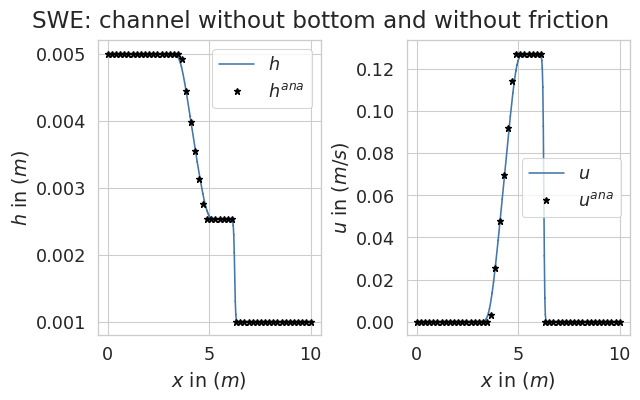

In [4]:
fig = plots_paper.plot_swe(os.path.join(settings.output_dir, settings.name + ".h5"))